In [12]:
from syntactic_similarity import syntactic_similarity_driver
from structural_similarity import structural_similarity_driver

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import openpyxl

ModuleNotFoundError: No module named 'nltk'

# generating the scores csv

In [2]:
def generate_scores_csv(df,path):
    firstIndex = path.find("n_")
    finalIndex = path.find("_",firstIndex+2)
    n = int(path[firstIndex+2:finalIndex])

    cols = [
        'task_id', 'prompt', 'sequence_similarity','edit_distance_score',
        'jaccard_similarity','cosine_similarity_score','sorensen_dice_coefficient',
        'hamming_distance_score', 'longest_common_subsequence', 'UnifiedDiff','TreeDiff'
    ] + [f'pass_rate_{i}' for i in range(n+1)]


    final = pd.DataFrame(columns = cols)

    #iterating over the rows of the dataframe
    for index, row in df.iterrows():
        #getting the reference and the generated text
        generated_codes = list(row[[f'code_{i}' for i in range(n+1)]])
            
        #computing the structural similarity
        _, structural_similarity_scores_dict,_ = structural_similarity_driver(generated_codes)
        
        #computing the syntactic similarity
        _, syntactic_similarity_scores_dict,_ = syntactic_similarity_driver(generated_codes)
        
        #dict to store the data
        dict = {'task_id': row['task_id'], 'prompt': row['prompt']}

        for i in range(n+1):
            dict['pass_rate_'+str(i)] = row['pass_rate_'+str(i)]
            
        #appending the syntactic similarity scores to the dict
        for key in syntactic_similarity_scores_dict.keys():
            dict[key] = syntactic_similarity_scores_dict[key]

        #appending the structural similarity scores to the dict
        for key in structural_similarity_scores_dict.keys():
            dict[key] = structural_similarity_scores_dict[key]

        temp = pd.DataFrame(dict, index=[0])

        #concatenating the dataframes
        final = pd.concat([final, temp], ignore_index=True)
    
    path = path.replace(".csv","_sim_score.csv")
    path = path.replace("RESULTS","RESULTS/final scores")
    final.to_csv(path, index=False)

In [ ]:
##### comments

import os

folder = '/home/g5/Desktop/G5/LLM-Code-Verifier/RESULTS/'
files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder,f))]

print(files)
print("\n\n\n")

def generate_scores_csv():
    for filename in files:
      if filename == 'dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1.csv':
        print(filename)
        df = pd.read_csv(f'{folder}/{filename}')
        firstIndex = filename.find("n_")
        finalIndex = filename.find("_",firstIndex+2)
        n = int(filename[firstIndex+2:finalIndex])

        cols = [
        'task_id', 'prompt', 'sequence_similarity','edit_distance_score',
        'jaccard_similarity','cosine_similarity_score','sorensen_dice_coefficient',
        'hamming_distance_score', 'longest_common_subsequence'] + [f'pass_rate_{i}' for i in range(n+1)]


        final = pd.DataFrame(columns = cols)
        
        #iterating over the rows of the dataframe
        for index, row in df.iterrows():
            #getting the reference and the generated text
            generated_comments = list(row[[f'functions-renamed_gpt-3.5-turbo_comment_{i}' for i in range(n+1)]])
            
            #computing the structural similarity
            #_, structural_similarity_scores_dict,_ = structural_similarity_driver(generated_codes)
        
            #computing the syntactic similarity
            _, syntactic_similarity_scores_dict,_ = syntactic_similarity_driver(generated_comments)
        
            #dict to store the data
            dict = {'task_id': row['task_id'], 'prompt': row['prompt']}

            for i in range(n+1):
                dict['pass_rate_'+str(i)] = row['pass_rate_'+str(i)]
            
            #appending the syntactic similarity scores to the dict
            for key in syntactic_similarity_scores_dict.keys():
                dict[key] = syntactic_similarity_scores_dict[key]

            #appending the structural similarity scores to the dict
            # for key in structural_similarity_scores_dict.keys():
            #    dict[key] = structural_similarity_scores_dict[key]

            temp = pd.DataFrame(dict, index=[0])

            #concatenating the dataframes
            final = pd.concat([final, temp], ignore_index=True)
    
        #path = path.replace(".csv","_sim_score.csv")
        #path = path.replace("RESULTS","RESULTS/final scores")
        path = '/home/g5/Desktop/G5/LLM-Code-Verifier/RESULTS/commented_files/lyxical_scores/3.5, 5, 0, 1 scores(3.5 and 4, renamed and not renamed)/'+ filename.replace(".csv","f_renamed_comments_gpt-3.5_sim_score.csv")
        final = final.drop([f'pass_rate_{i}' for i in range(n)], axis=1)
        final.to_csv(path, index=False)

        print("Visualizing the scores of the file ",filename)
        other_folder = '/home/g5/Desktop/G5/LLM-Code-Verifier/RESULTS'
        new_file_path = f'{other_folder}/{filename}'
        new_file_path = new_file_path.replace("trial_1","trial_3")
        results2 = pd.read_csv(new_file_path)
        df = pd.merge(results2, final, on="task_id")

        df = df[df["task_id"] != 'HumanEval/32']
        df["avg_pass_rate"] = df[[f'pass_rate_{i}' for i in range(n)]].sum(axis=1)/n
        df.to_csv(path, index=False)
        #df.to_csv('/home/g5/Desktop/G5/LLM-Code-Verifier/RESULTS/commented_files/f_renamed/scores/'+filename)

        df = df.sort_values(by='avg_pass_rate', ascending=True)

    #scoring columns
        scores_columns = ['sequence_similarity','edit_distance_score','jaccard_similarity','cosine_similarity_score','sorensen_dice_coefficient','hamming_distance_score','longest_common_subsequence']
   # scores_columns = ['sequence_similarity','UnifiedDiff']

    #print the number of data points that has the avg pass rate of 100
        print("number of data points that has the avg pass rate = 100 ",len(df[df['avg_pass_rate'] == 100] )/ len(df))

        corrs=-2
    
    #plot the avg pass rate with the task id and a score metrics
        for score in scores_columns:
            print("The correlation between the average pass rate and",score,"is",df['avg_pass_rate'].corr(df[score]))
            if df['avg_pass_rate'].corr(df[score]) > corrs:
                corrs = df['avg_pass_rate'].corr(df[score])
            

        #plot the avg pass rate wih color red and sequence similarity with color blue
            plt.figure(figsize=(25,10))
            plt.scatter(df["task_id"] ,df[score]*100,color='blue')
            plt.scatter(df["task_id"],df['avg_pass_rate'],color='red')
            plt.xlabel('Task ID')
            #rotate the x axis labels
            plt.xticks(ticks = [i for i in range(len(df))],labels = [i for i in range(len(df))], rotation=90)
            plt.ylabel('Scores')
            plt.legend([score,'Average Pass Rate'])
        
            plt.title('Average Pass Rate vs ' + score)
       #     plt.grid()
            plt.show()

    
        print("--------------------------------------------------------------------")

generate_scores_csv()

# reading the files

In [4]:
# Get a list of all CSV files in the directory
#csv_files = glob.glob('./RESULTS/*.csv')
csv_files = glob.glob('./RESULTS/trial 3/*.csv')

# Loop over the files and read them into pandas DataFrames
for file in csv_files:
    df = pd.read_csv(file)
    generate_scores_csv(df,file)
    print("Scores generated for ", file)

print("Scores generated successfully")

/tmp/ipykernel_149044/228379626.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/trial 3/dataset_HumanEval_model_gpt-3.5-turbo_n_3_tempr_0_temps_1_trial_3.csv


/tmp/ipykernel_149044/228379626.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/trial 3/dataset_HumanEval_model_gpt-3.5-turbo_n_15_tempr_0_temps_1_trial_3.csv


/tmp/ipykernel_149044/228379626.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/trial 3/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_1_temps_1_trial_3.csv


/tmp/ipykernel_149044/228379626.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/trial 3/dataset_HumanEval_model_gpt-3.5-turbo_n_10_tempr_0_temps_1_trial_3.csv


/tmp/ipykernel_149044/228379626.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/trial 3/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_3.csv


/tmp/ipykernel_149044/228379626.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/trial 3/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_0_temps_1.5_trial_3.csv


/tmp/ipykernel_149044/228379626.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/trial 3/dataset_HumanEval_model_gpt-3.5-turbo_n_15_tempr_1_temps_1_trial_3.csv


/tmp/ipykernel_149044/228379626.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/trial 3/dataset_HumanEval_model_gpt-3.5-turbo_n_15_tempr_1_temps_1.3_trial_3.csv


/tmp/ipykernel_149044/228379626.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/trial 3/dataset_HumanEval_model_gpt-4-turbo-preview_n_5_tempr_0_temps_1_trial_3.csv
Scores generated successfully


# visualizations

In [30]:
def visualize(df,path):
    print("Visualizing the scores of the file ",path)
    firstIndex = path.find("n_")
    finalIndex = path.find("_",firstIndex+2)
    n = int(path[firstIndex+2:finalIndex])
    # print(df.index)

    df['avg_pass_rate'] = df[[f'pass_rate_{i}' for i in range(n+1)]].mean(axis=1)
    #sort by avg pass rate
    df = df.sort_values(by='avg_pass_rate',ascending=True)
    #scoring columns
   # scores_columns = ['sequence_similarity','edit_distance_score','jaccard_similarity','cosine_similarity_score','sorensen_dice_coefficient','hamming_distance_score','longest_common_subsequence','UnifiedDiff','TreeDiff']
    scores_columns = ['sequence_similarity','UnifiedDiff']
    scores_columns = ['UnifiedDiff','edit_distance_score']

    #print the number of data points that has the avg pass rate of 100
    print("number of data points that has the avg pass rate = 100 ",len(df[df['avg_pass_rate'] == 100] )/ len(df))

    corrs=-2
    file = ""
    #plot the avg pass rate with the task id and a score metrics
    for score in scores_columns:
        print("The correlation between the average pass rate and",score,"is",df['avg_pass_rate'].corr(df[score]))
        if df['avg_pass_rate'].corr(df[score]) > corrs:
            corrs = df['avg_pass_rate'].corr(df[score])
            file = path

        #plot the avg pass rate wih color red and sequence similarity with color blue
        plt.figure(figsize=(15,10))
        plt.scatter(df["task_id"] ,df[score]*100,color='blue')
        plt.scatter(df["task_id"],df['avg_pass_rate'],color='red')
        plt.xlabel('Task ID')
        #rotate the x axis labels
        plt.xticks(ticks = [i for i in range(len(df))],labels = [i for i in range(len(df))], rotation=90)
        plt.ylabel('Scores')
        plt.legend([score,'Average Pass Rate'])
        display_path = path.split("/")[-1]
        display_path = display_path.replace("_trial_1_sim_score.csv","")
        plt.title('Average Pass Rate vs ' + score + " \nConfig: " + display_path)
       # plt.grid()
        plt.show()

    print("Visualizing the scores of the file ",path," completed")
    print("--------------------------------------------------------------------")


    print("The file with the highest correlation between the average pass rate and a score metric is ",file," with a correlation of ",corrs)

    


# stats

In [10]:
def generate_stats(df,path):
    print("generating stats of the file ",path)
    firstIndex = path.find("n_")
    finalIndex = path.find("_",firstIndex+2)
    n = int(path[firstIndex+2:finalIndex])

    df['avg_pass_rate'] = df[[f'pass_rate_{i}' for i in range(n+1)]].mean(axis=1)
    #sort by avg pass rate
    df = df.sort_values(by='avg_pass_rate',ascending=True)
    #scoring columns
    scores_columns = ['sequence_similarity','edit_distance_score','jaccard_similarity','cosine_similarity_score','sorensen_dice_coefficient','hamming_distance_score','longest_common_subsequence','UnifiedDiff','TreeDiff']
    dict = {}
    #plot the avg pass rate with the task id and a score metrics
    for score in scores_columns:
        dict[score] = df['avg_pass_rate'].corr(df[score]).round(2)
    
    return dict


        


# looping to get the visuals and stats

In [ ]:
# Get a list of all CSV files in the directory
#csv_files = glob.glob('./RESULTS/final scores/*.csv')
import glob
import pandas as pd
csv_files = glob.glob('./RESULTS/final scores/trial 3/*.csv')

stats =pd.DataFrame()
# Loop over the files and read them into pandas DataFrames
for file in csv_files:
    df = pd.read_csv(file)
    df = df[df["task_id"] != 'HumanEval/32']
    visualize(df,file)
    
    dict = {}

    dict = generate_stats(df,file)
    dict['file'] = file

    #generate a dataframe from the dict
    temp = pd.DataFrame(dict, index=[0])
    #reorder the columns to have the file column as the first column
    cols = temp.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    temp = temp[cols]
    
    stats = pd.concat([stats,temp], ignore_index=True)

print("Scores generated successfully")

# exporting the stats to CSV and Excel files

In [10]:
# stats = (stats.T)
# stats.to_csv("RESULTS/stats.csv", index=True)
# stats.to_excel("RESULTS/stats.xlsx", index=True)

stats = (stats.T)
stats.to_csv("RESULTS/stats_comments.csv", index=True)
stats.to_excel("RESULTS/stats_comments.xlsx", index=True)

In [168]:
stats

,0,1,2,3,4,5,6,7
file,./RESULTS/final scores/dataset_HumanEval_model...,./RESULTS/final scores/dataset_HumanEval_model...,./RESULTS/final scores/dataset_HumanEval_model...,./RESULTS/final scores/dataset_HumanEval_model...,./RESULTS/final scores/dataset_HumanEval_model...,./RESULTS/final scores/dataset_HumanEval_model...,./RESULTS/final scores/dataset_HumanEval_model...,./RESULTS/final scores/dataset_HumanEval_model...
sequence_similarity,0.28,0.28,0.23,0.47,0.35,0.09,0.21,0.3
edit_distance_score,0.27,0.27,0.19,0.43,0.34,0.08,0.19,0.28
jaccard_similarity,0.23,0.27,0.17,0.4,0.29,0.13,0.16,0.3
cosine_similarity_score,0.28,0.26,0.16,0.43,0.24,0.1,0.21,0.3
sorensen_dice_coefficient,0.1,0.11,0.07,0.25,0.09,-0.03,0.05,0.19
hamming_distance_score,0.17,0.19,0.07,0.3,0.22,0.08,0.08,0.18
longest_common_subsequence,0.24,0.24,0.14,0.35,0.27,0.08,0.14,0.26
UnifiedDiff,0.3,0.25,0.3,0.42,0.27,0.15,0.28,0.33
TreeDiff,0.28,0.24,0.22,0.37,0.23,0.12,0.25,0.28


In [9]:
from syntactic_similarity import syntactic_similarity_driver
from structural_similarity import structural_similarity_driver

import pandas as pd
import glob
import os

# Get a list of all CSV files in the directory that include 'APPS' in their name
csv_files = glob.glob('./RESULTS/*APPS*.csv')

# Loop over the files and read them into pandas DataFrames
for file in csv_files:
    start_row = next((i for i, row in enumerate(pd.read_csv(file, chunksize=1)) if row.iat[0, 0] == 'APPS/301'), None)
    if start_row is not None:
        df = pd.read_csv(file, skiprows=range(1, start_row+1))
    else:
        continue
    
    firstIndex = file.find("n_")
    finalIndex = file.find("_",firstIndex+2)
    n = int(file[firstIndex+2:finalIndex])

    cols = [
        'task_id', 'prompt', 'sequence_similarity','edit_distance_score',
        'jaccard_similarity','cosine_similarity_score','sorensen_dice_coefficient',
        'hamming_distance_score', 'longest_common_subsequence', 'UnifiedDiff','TreeDiff'
    ] + [f'pass_rate_{i}' for i in range(n+1)]

    final = pd.DataFrame(columns = cols)

    #iterating over the rows of the dataframe
    for index, row in df.iterrows():
        #getting the reference and the generated text
        generated_codes = list(row[[f'code_{i}' for i in range(n+1)]])
            
        #computing the structural similarity
        _, structural_similarity_scores_dict,_ = structural_similarity_driver(generated_codes)
        #computing the syntactic similarity
        _, syntactic_similarity_scores_dict,_ = syntactic_similarity_driver(generated_codes)
        
        #dict to store the data
        dict = {'task_id': row['task_id'], 'prompt': row['prompt']}
        for i in range(n+1):
            dict['pass_rate_'+str(i)] = row['pass_rate_'+str(i)]
            
        #appending the syntactic similarity scores to the dict
        for key in syntactic_similarity_scores_dict.keys():
            dict[key] = syntactic_similarity_scores_dict[key]
        #appending the structural similarity scores to the dict
        for key in structural_similarity_scores_dict.keys():
            dict[key] = structural_similarity_scores_dict[key]

        temp = pd.DataFrame(dict, index=[0])
        #concatenating the dataframes
        final = pd.concat([final, temp], ignore_index=True)
    
    file = file.replace(".csv","_sim_score.csv")
    file = file.replace("RESULTS","RESULTS/final scores")

    if os.path.exists(file):
        existing_df = pd.read_csv(file)
        final = pd.concat([existing_df, final], ignore_index=True)

    final.to_csv(file, mode='w', index=False)

    print("Scores generated for ", file)

print("Scores generated successfully")

/tmp/ipykernel_156036/3392834569.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/final scores/dataset_APPS_model_gpt-3.5-turbo_n_15_tempr_0_temps_1_trial_1_sim_score.csv


/tmp/ipykernel_156036/3392834569.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/final scores/dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1.5_trial_1_sim_score.csv


/tmp/ipykernel_156036/3392834569.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/final scores/dataset_APPS_model_gpt-3.5-turbo_n_3_tempr_0_temps_1_trial_1_sim_score.csv


/tmp/ipykernel_156036/3392834569.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/final scores/dataset_APPS_model_gpt-3.5-turbo_n_10_tempr_0_temps_1_trial_1_sim_score.csv


/tmp/ipykernel_156036/3392834569.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/final scores/dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_1_temps_1_trial_1_sim_score.csv


/tmp/ipykernel_156036/3392834569.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, temp], ignore_index=True)


Scores generated for  ./RESULTS/final scores/dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1_sim_score.csv
Scores generated successfully


In [5]:
import glob
import pandas as pd
csv_files = glob.glob('RESULTS/APPS/APPS results/*.csv')

csv_files



['RESULTS/APPS/APPS results\\dataset_APPS_model_gpt-3.5-turbo_n_10_tempr_0_temps_1_trial_1_sim_score.csv',
 'RESULTS/APPS/APPS results\\dataset_APPS_model_gpt-3.5-turbo_n_15_tempr_0_temps_1_trial_1_sim_score.csv',
 'RESULTS/APPS/APPS results\\dataset_APPS_model_gpt-3.5-turbo_n_3_tempr_0_temps_1_trial_1_sim_score.csv',
 'RESULTS/APPS/APPS results\\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1.5_trial_1_sim_score.csv',
 'RESULTS/APPS/APPS results\\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1_sim_score.csv',
 'RESULTS/APPS/APPS results\\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_1_temps_1_trial_1_sim_score.csv']

In [7]:
csv_files = ['RESULTS/APPS/APPS results\\dataset_APPS_model_gpt-3.5-turbo_n_15_tempr_0_temps_1_trial_1_sim_score.csv',
             'RESULTS/APPS/APPS results\\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1.5_trial_1_sim_score.csv',
             'RESULTS/APPS/APPS results\\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1_sim_score.csv']


Visualizing the scores of the file  RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_15_tempr_0_temps_1_trial_1_sim_score.csv
number of data points that has the avg pass rate = 100  0.02594810379241517
The correlation between the average pass rate and UnifiedDiff is 0.3016295835760816


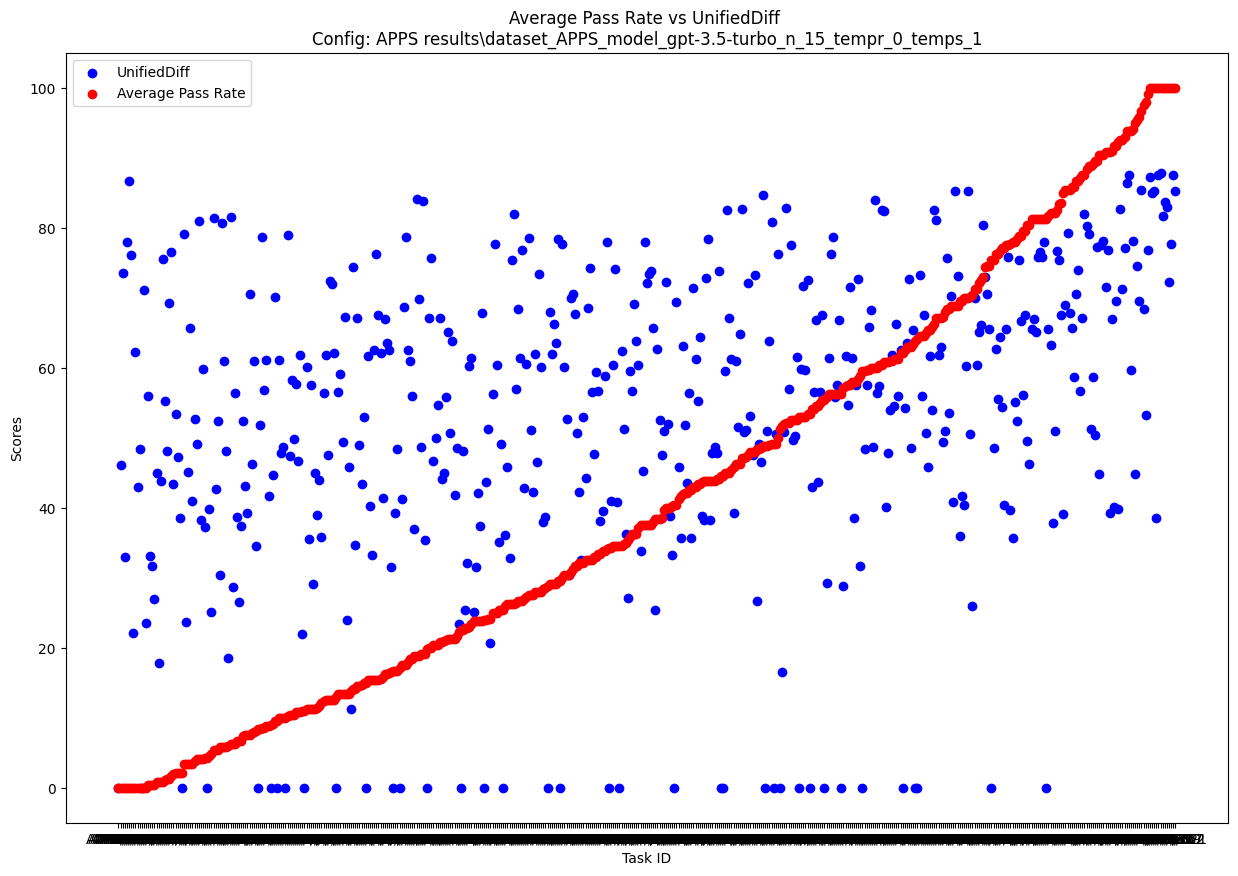

The correlation between the average pass rate and edit_distance_score is 0.45015959770188274


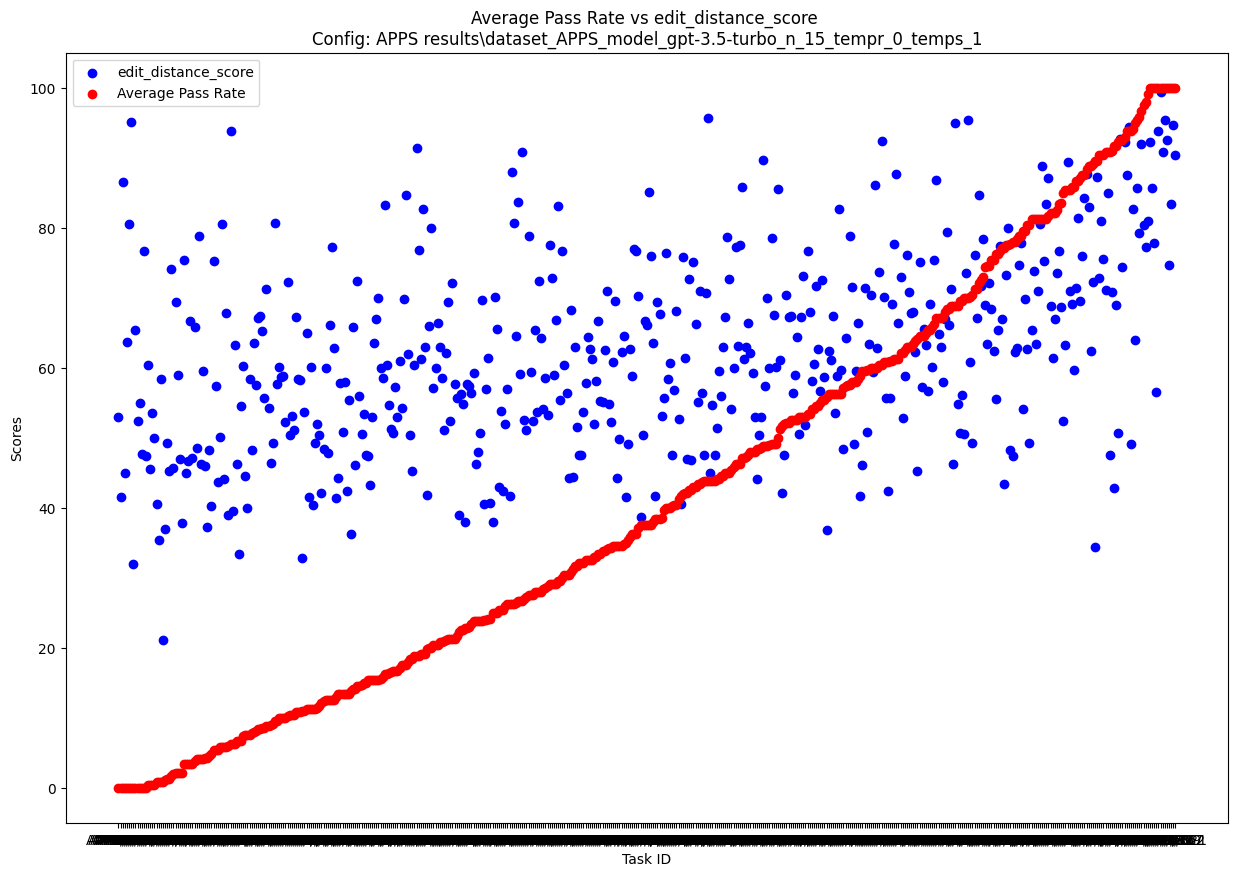

Visualizing the scores of the file  RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_15_tempr_0_temps_1_trial_1_sim_score.csv  completed
--------------------------------------------------------------------
The file with the highest correlation between the average pass rate and a score metric is  RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_15_tempr_0_temps_1_trial_1_sim_score.csv  with a correlation of  0.45015959770188274
generating stats of the file  RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_15_tempr_0_temps_1_trial_1_sim_score.csv
Visualizing the scores of the file  RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1.5_trial_1_sim_score.csv
number of data points that has the avg pass rate = 100  0.01996007984031936
The correlation between the average pass rate and UnifiedDiff is 0.4027904155049815


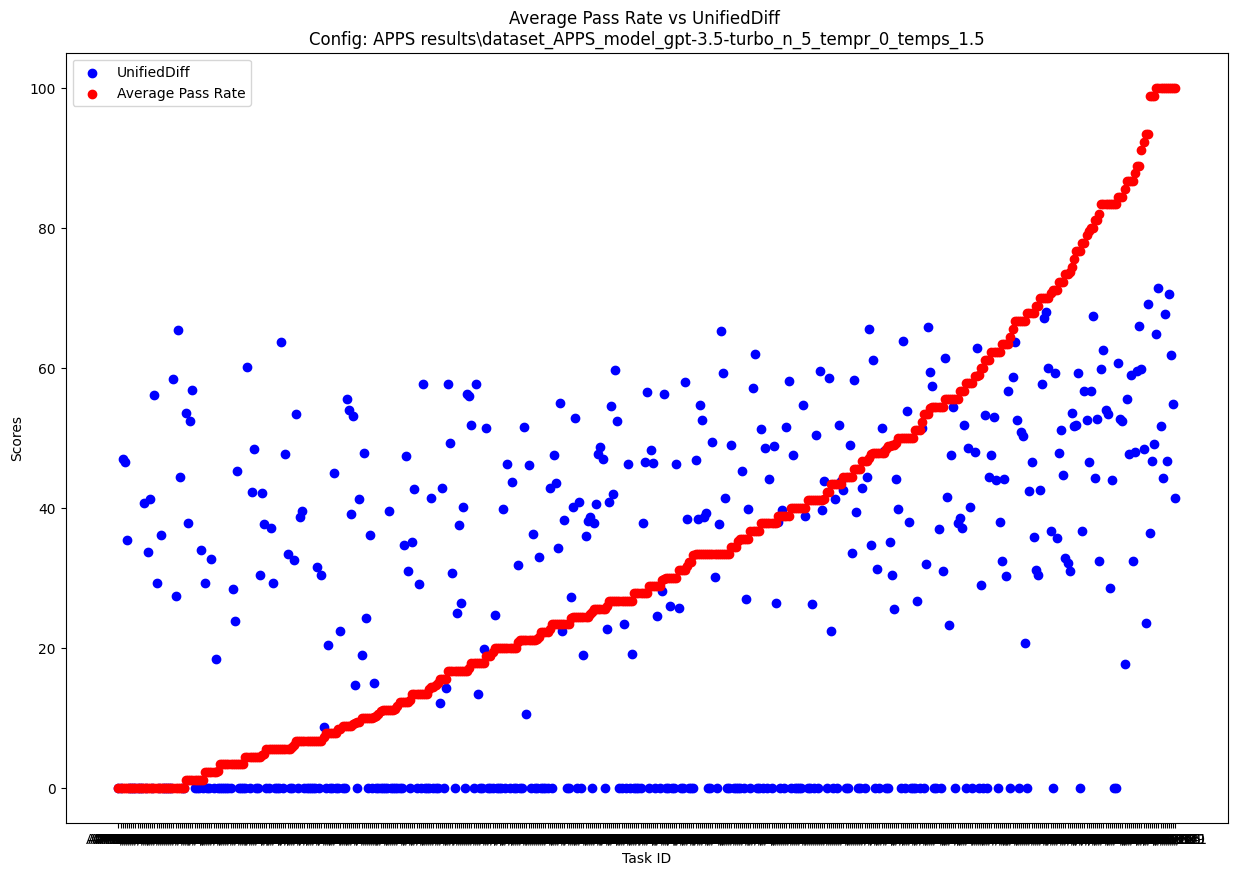

The correlation between the average pass rate and edit_distance_score is 0.5357065095025212


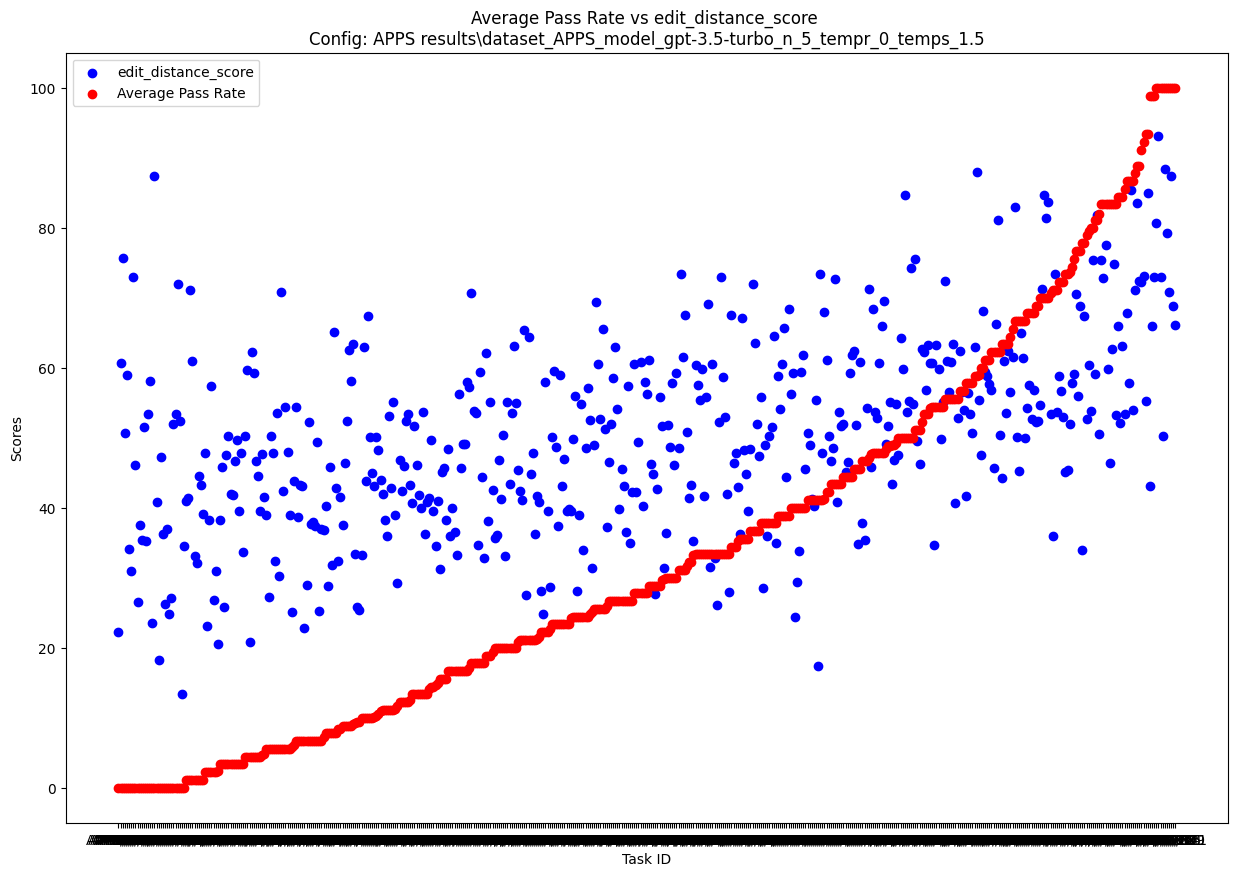

Visualizing the scores of the file  RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1.5_trial_1_sim_score.csv  completed
--------------------------------------------------------------------
The file with the highest correlation between the average pass rate and a score metric is  RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1.5_trial_1_sim_score.csv  with a correlation of  0.5357065095025212
generating stats of the file  RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1.5_trial_1_sim_score.csv
Visualizing the scores of the file  RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1_sim_score.csv
number of data points that has the avg pass rate = 100  0.05389221556886228
The correlation between the average pass rate and UnifiedDiff is 0.3445343558230684


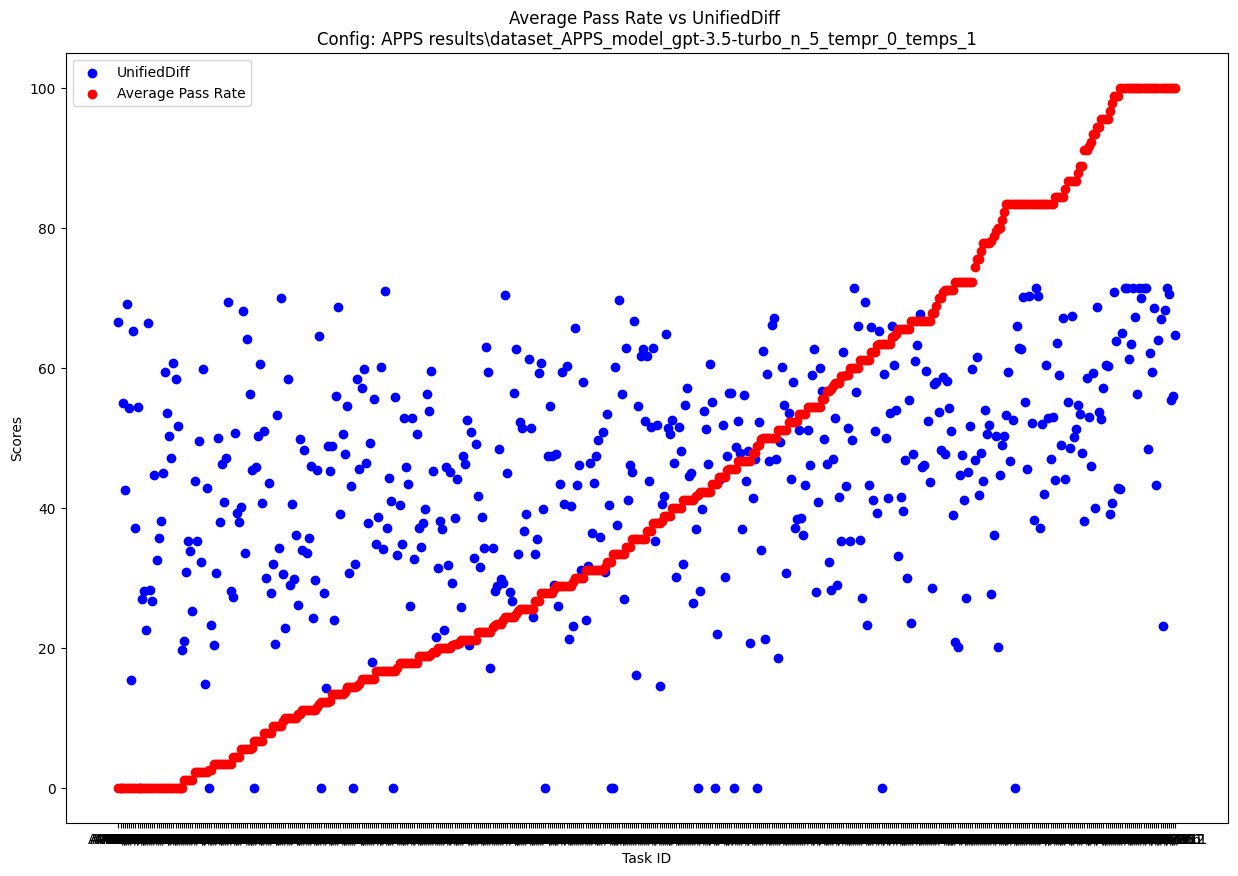

The correlation between the average pass rate and edit_distance_score is 0.4535339592973748


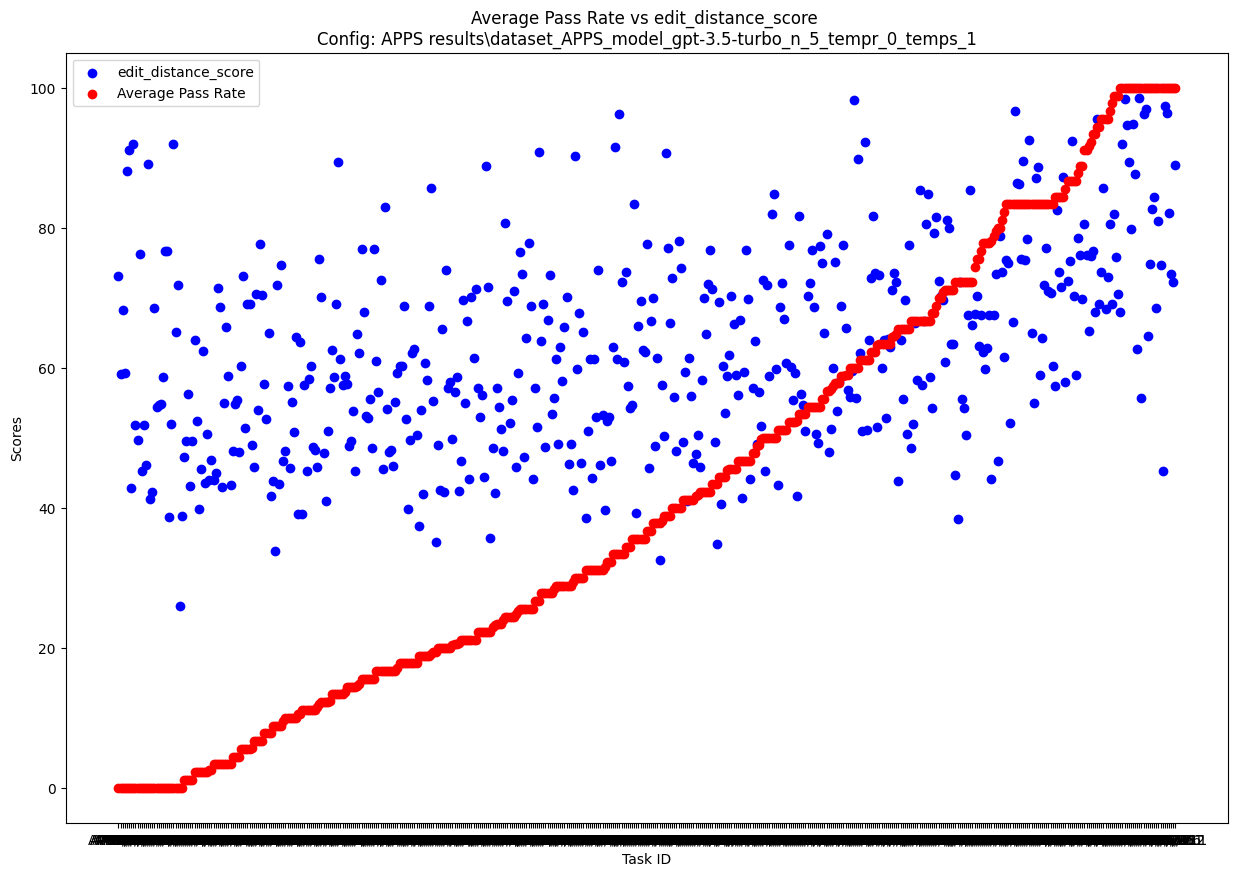

Visualizing the scores of the file  RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1_sim_score.csv  completed
--------------------------------------------------------------------
The file with the highest correlation between the average pass rate and a score metric is  RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1_sim_score.csv  with a correlation of  0.4535339592973748
generating stats of the file  RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1_sim_score.csv
Scores generated successfully


In [31]:
import matplotlib.pyplot as plt
# Get a list of all CSV files in the directory
#csv_files = glob.glob('./RESULTS/final scores/*.csv')
# import glob
# import pandas as pd
# csv_files = glob.glob('RESULTS/APPS/*.csv')

stats =pd.DataFrame()
# Loop over the files and read them into pandas DataFrames
for file in csv_files:
    df = pd.read_csv(file)
    df = df[df["task_id"] != 'HumanEval/32']
    visualize(df,file)
    
    dict = {}

    dict = generate_stats(df,file)
    dict['file'] = file

    #generate a dataframe from the dict
    temp = pd.DataFrame(dict, index=[0])
    #reorder the columns to have the file column as the first column
    cols = temp.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    temp = temp[cols]
    
    stats = pd.concat([stats,temp], ignore_index=True)

print("Scores generated successfully")

In [14]:
stats = (stats.T)
stats.to_csv("RESULTS/stats_comments.csv", index=True)
stats.to_excel("RESULTS/stats_comments.xlsx", index=True)

In [16]:
#make the width of the columns to be the maximum
pd.set_option('display.max_colwidth', None)

In [23]:
#remove the sorsen dice coefficient and hamming distance score 

stats = stats.drop('sorensen_dice_coefficient', axis=0)
stats = stats.drop('hamming_distance_score', axis=0)

In [24]:
stats

,0,1,2
file,RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_15_tempr_0_temps_1_trial_1_sim_score.csv,RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1.5_trial_1_sim_score.csv,RESULTS/APPS/APPS results\dataset_APPS_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1_sim_score.csv
sequence_similarity,0.44,0.51,0.43
edit_distance_score,0.45,0.54,0.45
jaccard_similarity,0.45,0.53,0.45
cosine_similarity_score,0.36,0.44,0.35
longest_common_subsequence,0.34,0.37,0.34
UnifiedDiff,0.3,0.4,0.34
TreeDiff,0.24,0.37,0.29
